<a href="https://colab.research.google.com/github/sepehrsardooeinasab/Face_Boundry_and_Facial_Landmark_Detection/blob/master/part2_facial_landmark_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial landmark detection

## Config Collab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Global Variables

In [2]:
BASE_PATH = r'/content/drive/MyDrive/CV2022/'
NEW_WIDTH_HEIGHT = 224
MINI_BATCH_SIZE = 32
EPOCHS = 5
SEED = 0

## Unzip Data

In [3]:
!unzip -qq {BASE_PATH}WiderSelected.zip -d {BASE_PATH}

replace /content/drive/MyDrive/CV2022/WiderSelected/annotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Import neccessary packages

In [3]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Reshape, MaxPooling2D, Conv2D, Activation

## Set seeds

In [4]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)

set_seeds(SEED)

## Train, Validation and Test split

In [5]:
num_images = 4275

RANGE_TRAIN = [0, int(0.8*num_images)]
RANGE_VAL = [int(0.8*num_images), int(0.82*num_images)]
RANGE_TEST = [int(0.82*num_images), int(num_images)]

print("Range train: {:0>4d} - {:0>4d}".format(RANGE_TRAIN[0], RANGE_TRAIN[1]))
print("Range val:   {:0>4d} - {:0>4d}".format(RANGE_VAL[0], RANGE_VAL[1]))
print("Range test:  {:0>4d} - {:0>4d}".format(RANGE_TEST[0], RANGE_TEST[1]))

Range train: 0000 - 3420
Range val:   3420 - 3505
Range test:  3505 - 4275


## Make set function

In [6]:
def make_set(start_index, end_index):
    annotations_text = open(BASE_PATH + "WiderSelected/annotations.txt", 'r')
    lines = annotations_text.readlines()
    annotations_text.close()
    image_counter = 0
    pointer = 0
    images = []
    labels = []
    
    while pointer<=len(lines):
        if start_index <= image_counter < end_index:
            path_image = lines[pointer].strip()
            image = cv2.imread(BASE_PATH + "WiderSelected/train/" + path_image)
            image_copy = image.copy()
            current_heigth, current_width = image.shape[0], image.shape[1]
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            
            for num_face in range(num_faces):
                face_bbs, landmarks = lines[pointer].split()[:4], lines[pointer].split()[4:]
                x, y, w, h = int(face_bbs[0]), int(face_bbs[1]), int(face_bbs[2]), int(face_bbs[3])
                timage = image_copy[y:y+h, x:x+w]
                resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
                images.append(resized)

                face_landmarks = []
                for landmark_index in range(0, len(landmarks), 2):
                    x_landmark = int((int(landmarks[landmark_index]) - x) * NEW_WIDTH_HEIGHT / w)
                    y_landmark = int((int(landmarks[landmark_index+1]) - y) * NEW_WIDTH_HEIGHT / h)  
                    face_landmarks.append([x_landmark, y_landmark])
                    
                pointer += 1
                labels.append(face_landmarks)
                
        elif image_counter >= end_index:
            break   
        else:
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            for i in range(num_faces):
                pointer += 1
                
        image_counter += 1
        
    X = np.array(images)
    Y = np.array(labels)
    return X, Y

## CNN model

In [7]:
def CNN_model(shape_input):
    input = Input(shape=shape_input)
    t = Conv2D(filters=64, kernel_size=3, activation="relu")(input)
    t = Conv2D(filters=64, kernel_size=3, activation="relu")(t)
    t = Conv2D(filters=64, kernel_size=3, activation="relu")(t)
    t = MaxPooling2D(pool_size=2)(t)
    t = Conv2D(filters=98, kernel_size=3, activation="relu")(t)
    t = Conv2D(filters=98, kernel_size=3, activation="relu")(t)
    t = Conv2D(filters=98, kernel_size=3, activation="relu")(t)
    t = MaxPooling2D(pool_size=2)(t)
    t = Flatten()(t)
    t = Dense(68*2, activation="sigmoid")(t)
    t = Reshape((68, 2))(t)
    return Model(input, t)

In [8]:
model = CNN_model((NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT, 3))

model_checkpoint = ModelCheckpoint(BASE_PATH + "Models/CNN_LM.h5", monitor='val_loss',
                                   verbose=1, save_best_only=True, save_weights_only=False)
model.compile(Adam(learning_rate=3e-4), loss="mse", metrics=["mae"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 98)      56546     
                                                             

## Make Train and Val sets, also normalize them

In [9]:
X_train, Y_train = make_set(RANGE_TRAIN[0], RANGE_TRAIN[1])
X_val, Y_val = make_set(RANGE_VAL[0], RANGE_VAL[1])
X_train = X_train / 255.0
X_val = X_val / 255.0
Y_train = Y_train / NEW_WIDTH_HEIGHT
Y_val = Y_val / NEW_WIDTH_HEIGHT

print("Size Train:", X_train.shape[0])
print("Size Validation:", X_val.shape[0])

Size Train: 2129
Size Validation: 99


## Train the model

In [10]:
history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=MINI_BATCH_SIZE, validation_data=(X_val, Y_val), callbacks=[model_checkpoint])

Epoch 1/5
67/67 [==============================] - ETA: 0s - loss: 0.0092 - mae: 0.0688 
Epoch 1: val_loss improved from inf to 0.00595, saving model to /content/drive/MyDrive/CV2022/Models/CNN_LM.h5
67/67 [==============================] - 1247s 19s/step - loss: 0.0092 - mae: 0.0688 - val_loss: 0.0059 - val_mae: 0.0563
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0404 
Epoch 2: val_loss improved from 0.00595 to 0.00265, saving model to /content/drive/MyDrive/CV2022/Models/CNN_LM.h5
67/67 [==============================] - 1244s 19s/step - loss: 0.0034 - mae: 0.0404 - val_loss: 0.0026 - val_mae: 0.0368
Epoch 3/5
67/67 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0325 
Epoch 3: val_loss improved from 0.00265 to 0.00216, saving model to /content/drive/MyDrive/CV2022/Models/CNN_LM.h5
67/67 [==============================] - 1255s 19s/step - loss: 0.0022 - mae: 0.0325 - val_loss: 0.0022 - val_mae: 0.0327
Epoch 4/5
67/67 [=========

## Plot History

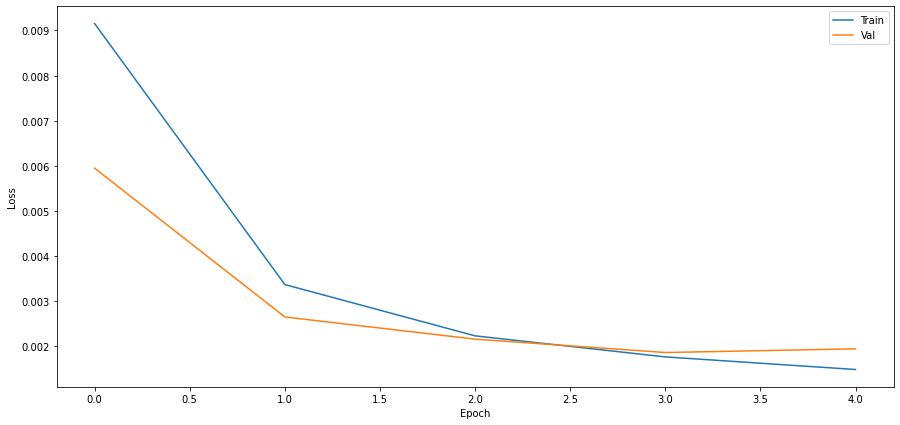

In [11]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.plot(history.epoch, np.array(history.history['loss']), label='Train')
ax.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val')
plt.legend()
plt.show()

## Test an image

In [12]:
model = load_model(BASE_PATH + "Models/CNN_LM.h5")

In [13]:
def test_image(image_index):
    annotations_text = open(BASE_PATH + "WiderSelected/annotations.txt", 'r')
    lines = annotations_text.readlines()
    annotations_text.close()
    image_counter = 0
    pointer = 0
    images = []
    
    while pointer<=len(lines):
        if image_index == image_counter:
            path_image = lines[pointer].strip()
            image = cv2.imread(BASE_PATH + "WiderSelected/train/" + path_image)
            image_copy = image.copy()
            current_heigth, current_width = image.shape[0], image.shape[1]
            resized_image = cv2.resize(image, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT), (NEW_WIDTH_HEIGHT/current_width),
                                       (NEW_WIDTH_HEIGHT/current_heigth), interpolation=cv2.INTER_CUBIC)
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            
            for num_face in range(num_faces):
                face_bbs = lines[pointer].split()[:4]
                x, y, w, h = int(face_bbs[0]), int(face_bbs[1]), int(face_bbs[2]), int(face_bbs[3])
                timage = image_copy[y:y+h, x:x+w]
                resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
                images.append(resized)
                pointer += 1                
        elif image_counter > image_index:
            break   
        else:
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            for i in range(num_faces):
                pointer += 1
                
        image_counter += 1
    
    plt.figure(figsize=(15, 7))
    plt.imshow(resized_image[:,:,::-1])
    plt.show()

    if len(images)==1:
        landmarks = (model.predict(np.expand_dims(images[0], axis=0)/ 255.0) * NEW_WIDTH_HEIGHT).astype(int)

        for landmark in landmarks[0]:
            cv2.circle(images[0], (landmark[0], landmark[1]),
                       radius=1, color=(0, 255, 0))
        
        plt.figure(figsize=(15, 7))
        plt.imshow(images[0][:,:,::-1])
        plt.show()
    else:
        X = np.array(images) / 255.0
        landmarks = (model.predict(X) * NEW_WIDTH_HEIGHT).astype(int)
        
        for e, image in enumerate(images):
            for landmark in landmarks[e]:
                cv2.circle(image, (landmark[0], landmark[1]),
                           radius=1, color=(0, 255, 0))
                
        fig, subplots = plt.subplots(1, len(images), figsize=(15, 7))

        for e, ax in enumerate(subplots):
            ax.imshow(images[e][:,:,::-1])
                
        plt.show()

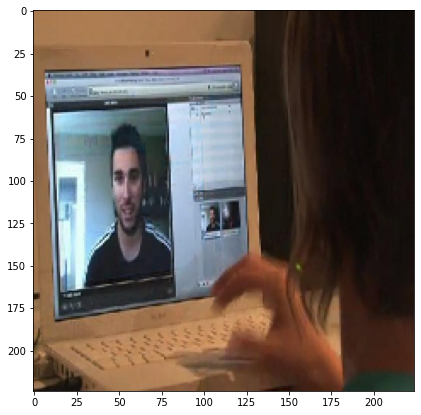

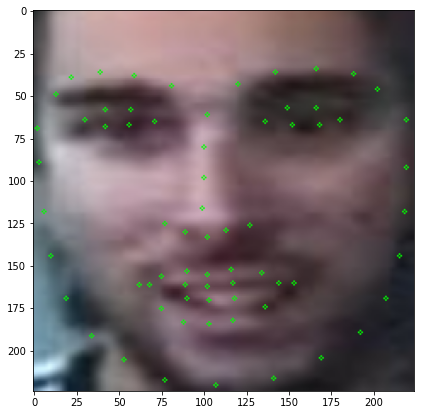

In [14]:
test_image(RANGE_TEST[0]+69)

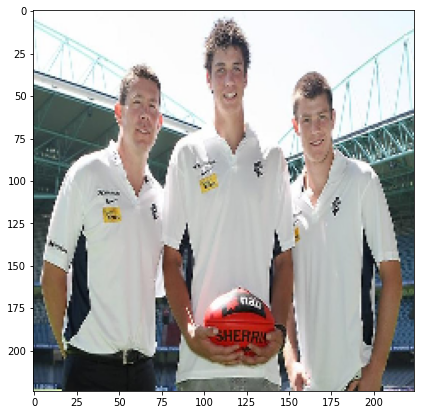

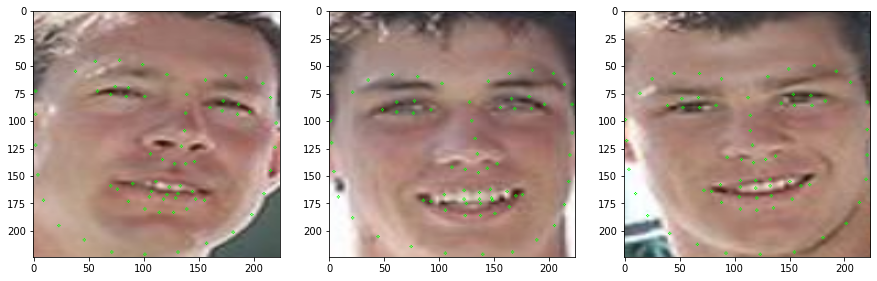

In [15]:
test_image(RANGE_TEST[0]+68)